# Парсинг файлов первого типа.

Пример такого файла можно найти [тут](./Test%20docs/Summary%204SА%20Malynskiy%20lishosp%20APK%202021%20EN.pdf).

Также файлы можно скачать по [ссылке](https://info.fsc.org/certificate.php). 
1. Далее выбрать пункт `Certificate Holder Login`. 
2. Выбрать `Country or Area`: **Ukraine**
3. Выбрать `Certificate Code` среднее поле `FM/COC`. Для документов первого типа нужно дополнительно выбрать `FC` в первом поле.

Основной задачей является парсинг pdf документа (определенного шаблона, типа), изъятие оттуда таблиц с информацией. А после, составление csv файла с преобразованной информацией. В конечном счете необходимо получить программ, которая будет самостоятельно обрабатывать файлы данного типа и составлять результирующую таблицу.

## Подготовка

In [1]:
import camelot # библиотека для извлечения таблиц
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
file = 'Test docs/Summary 4SА Malynskiy lishosp APK 2021 EN.pdf'

## Вычисление характеристик документа


### Посчитаем размеры документа
Это не очень быстрая операция. Думаю, что размеры документов будут совпадать для всех документов данного типа.

Под размерами документа я понимаю его максимальные координаты.

Точка с координатами $(0,0)$ находится в левом нижнем углу, а точка с максимальными координатами находится в правом верхнем углу. Про это можно почитать [тут](https://www.pdfscripting.com/public/PDF-Page-Coordinates.cfm).

**Однако** в библиотеке camelot есть свои особенности. Там сначала идет левый верхний угол, а потом нижний правый угол для обозначения области таблицы.
>`table_areas` accepts strings of the form x1,y1,x2,y2 where (x1, y1) -> top-left and (x2, y2) -> bottom-right in PDF coordinate space. In PDF coordinate space, the bottom-left corner of the page is the origin, with coordinates (0, 0).

In [3]:
from camelot import utils
layout, dim = utils.get_page_layout(file)
layout, dim

(<LTPage(27) 0.000,0.000,595.320,841.920 rotate=0>, (595.32, 841.92))

Как видим в данном документе 27 страниц. Его максимальные координаты это приблизительно $(600, 840)$

### Список нужных страниц и координаты начала и конца таблиц.

Pdf документ большой и в нем много таблиц. Нам не нужны все таблицы. Поэтому нужно найти страницу и координаты с которой начинаются нужны нам таблицы и страницу и координаты, где нужные таблицы заканчиваются (нужные табдицы идет последовательно, между ними нет ненужных таблиц).


Для решения этой проблемы будем использовать [pdfminer.six](https://github.com/pdfminer/pdfminer.six). Решение этой задачи было изложено [тут](https://stackoverflow.com/questions/22898145/how-to-extract-text-and-text-coordinates-from-a-pdf-file).

In [4]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
import pdfminer
from pdfminer.pdfinterp import resolve1

In [5]:
def get_optional_text(o) -> str:
    """Text of LTItem if available, otherwise empty string"""
    if hasattr(o, 'get_text'):
        return o.get_text().strip()
    return ''

Подобная функция для проверки текста была выбрана потому, что объекты в pdf файле могут содержать больше текста, чем указано в `target_text`.

In [6]:
def check_text_for_marker(target_text: str, object_text: str) -> bool:
    """
    function check text and if 
    target text is in object text return true
    else false

    target text is text that indicate start or end of desired area
    """
    if target_text in object_text:
        return True
    else:
        return False

##### Укажем метки начала и конца нужных нам таблиц.

Метка это номер страницы и координата по оси ординат ($y$)

In [7]:
start_text = '5.4.2. Minor conditions'
end_text = '6. INTERNAL CHAIN OF CUSTODY'

# Начальные значения мы их будем уточнять
start_page = 0
start_coord = 0
end_page = 0
end_coord = 0


In [8]:
with  open(file, 'rb') as fp:

    # Create a PDF parser object associated with the file object.
    parser = PDFParser(fp)

    # Create a PDF document object that stores the document structure.
    # Password for initialization as 2nd parameter
    document = PDFDocument(parser)

    # Check if the document allows text extraction. If not, abort.
    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed

    # Create a PDF resource manager object that stores shared resources.
    rsrcmgr = PDFResourceManager()

    # Create a PDF device object.
    device = PDFDevice(rsrcmgr)

    # BEGIN LAYOUT ANALYSIS
    # Set parameters for analysis.
    laparams = LAParams()

    # Create a PDF page aggregator object.
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)

    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # loop over all pages in the document
    num_page =0 
    for page in PDFPage.create_pages(document):
        num_page +=1
        # read the page into a layout object
        interpreter.process_page(page)
        layout = device.get_result()

        # loop over all objects in current page
        for obj in layout._objs:
            obj_text = get_optional_text(obj)
            if check_text_for_marker(start_text, get_optional_text(obj)):
                print(obj_text)
                print(''.join(f'{int(i)} ' for i in obj.bbox))
                print(num_page)

5.4.2. Minor conditions 
Minor conditions 31 (Mn-31)
56 597 208 640 
19


В итоге получили текст объекта с которого надо начинать искать таблицы, его координаты (левый нижний и правый верхний углы) и номер страницы.

Как видим в этом примере у нас отметка старта включает в себя лишний текст (он находится внутри таблицы). Поэтому нужно брать верхнюю координату по $y$.

In [9]:
def start_and_end_coords_pages(file_path: str) -> tuple:
    start_page = 0
    start_coord = 0
    end_page = 0
    end_coord = 0
    with  open(file_path, 'rb') as fp:

        # Create a PDF parser object associated with the file object.
        parser = PDFParser(fp)

        # Create a PDF document object that stores the document structure.
        # Password for initialization as 2nd parameter
        document = PDFDocument(parser)

        # Check if the document allows text extraction. If not, abort.
        if not document.is_extractable:
            raise PDFTextExtractionNotAllowed

        # Create a PDF resource manager object that stores shared resources.
        rsrcmgr = PDFResourceManager()

        # Create a PDF device object.
        device = PDFDevice(rsrcmgr)

        # BEGIN LAYOUT ANALYSIS
        # Set parameters for analysis.
        laparams = LAParams()

        # Create a PDF page aggregator object.
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)

        # Create a PDF interpreter object.
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        # loop over all pages in the document
        num_page =0 
        for page in PDFPage.create_pages(document):
            num_page +=1
            # read the page into a layout object
            interpreter.process_page(page)
            layout = device.get_result()

            # loop over all objects in current page
            for obj in layout._objs:
                obj_text = get_optional_text(obj)
                if check_text_for_marker(start_text, get_optional_text(obj)):
                    start_page = num_page
                    start_coord = obj.bbox[1]
                if check_text_for_marker(end_text, get_optional_text(obj)):
                    end_page = num_page
                    end_coord = obj.bbox[1]
    return (start_page, start_coord), (end_page, end_coord)

In [11]:
_pages_coords =  start_and_end_coords_pages(file)
start_page, start_coord = _pages_coords[0]
end_page, end_coord = _pages_coords[1]
start_page, start_coord, end_page, end_coord

(19, 597.268, 26, 530.398)

### Получение верха и низа страницы

Нам нужны только таблицы, нам не нужны колонтитулы или номера страниц. Поэтому я решил просто взять одну страницу и выделить из нее таблицы. Границы таблиц и будут верхом и низом страницы

In [60]:
tables = camelot.read_pdf(file, pages = '20', )
tables

<TableList n=2>

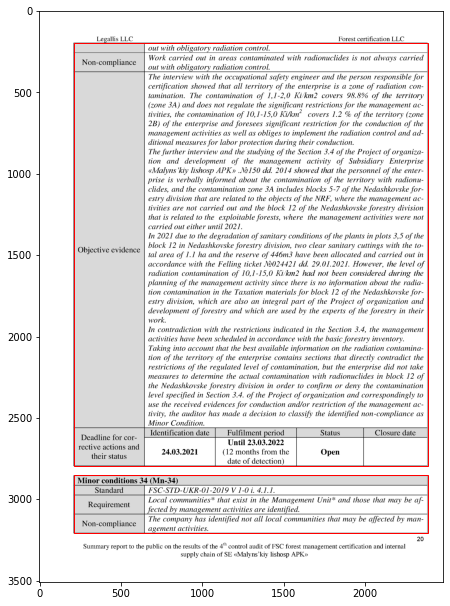

In [61]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()


In [62]:
top_page  = round(tables[0].cells[0][0].y2,0)
bottom_page = round(tables[-1].cells[-1][-1].y1, 0)

# Для удобства еще запишем глобальные переменные (чтобы узнавать, что это глобальные переменные)
TOP_PAGE, BOTTOM_PAGE = top_page, bottom_page 
top_page, bottom_page

(795.0, 72.0)

## Извлечение таблиц

При извлечении таблиц могут возникнуть следующие сложности

- Разрыв таблицы по страницам (первая часть таблицы на одной странице, вторая -- на следующей)
- Не всегда camelot распознает таблицу.

Для решения этих вопросов нужно решить и рассмотреть такие задачи
- определение полноты таблицы:
  - кол-во столбцов
  - кол-во рядов
  - наличие основных атрибутов:
    - заголовок `'Minor condition'`
    - поле `'Standard'`
    - поле `'Deadline for cor-\nrective actions and \ntheir status'`
    - поле `'Identification date'`
- Если таблица не полная, то это верх таблицы или ее низ:
  - Для верха таблицы выяснить:
    - заголовок `'Minor condition'`
    - поле `'Standard'` **Не уверен**.
    - Определить есть ли заголовок у последнего рядка таблицы, или там просто текст.
  - Для низа таблицы выяснить:
    - поле `'Deadline for cor-\nrective actions and \ntheir status'`
    - поле `'Identification date'`
    - Определить есть ли заголовок у первого рядка таблицы, или там просто текст.
- Таблица наверху или внизу (ее край рядом с верхом\низом страницы)
  - Верхняя граница таблицы находится рядом с верхом страницы (не выше на eps1 и не ниже на eps2)
  - Нижняя граница таблицы находится рядом с низом страницы (не выше на eps1 и не ниже на eps2)
- Склейка разорванных таблиц
  - распознать, что первая таблица неполная и **не нижняя**, а вторая -- неполная и нижняя.
  - Определить, есть ли атрибуты у последней и первой строк соответствующих таблиц
  - Вставить пустые столбцы в верхнюю таблицу (привести к правильному размеру по столбцам)
  - соединить таблицы. 
    - Если нет атрибута у верхней, то текст клеится к атрибуту нижней
    - Если нет атрибута у нижней, то текст клеится к атрибуту верхней
    - Если у обоих таблиц нет атрибута, то это ошибка.
- Распознавание нераспознанных таблиц. Я считаю, что это верхние части таблиц, которые обрезались страницей. Для решения этого нам поможет прошлый пункт, если прошлая таблица не находится внизу, а следующая таблица неполная (низ таблицы), то значит мы пропустили верхнюю часть таблицы.
  - Проверяем есть ли нераспознанная таблица. За таблицей, которая не находится внизу (до низа страницы есть место) и **нижняя** стоит неполная нижняя таблица. Это говорит о том, что мы пропустили маленькую таблицу, начало второй таблицы.
  - Определяем область нераспознанной таблицы
  - Распознаем ее при помощи алгоритма `stream`
  - Как показала практика, не распознаются маленькие таблицы у которых текст занимает всего одну строку. Однако если текст напротив атрибута занимает больше строк, то строки распознаются некорректно. Поэтому нужно будет сделать перевод распознанной таблицы в приличный вид (склейка строк)
    - определить количество аргументов и количество строк текста. 
    - Если аргумент стоит напротив текста и в строке выше него есть другой аргумент, то это то все хорошо. Это значит, что для этого аргумента текст распознался одной строкой. 
    - **Пока не делаю** Если над аргументом есть пустые аргументы, то текст в этих строках принадлежит аргументу. Также будем Считать, что текст распознается симметрично. Поэтому посмотрим сколько строк текста над аргументом принадлежат ему и потом столько же строк текста под аргументом присвоим этому аргументу. **Под вопросом**

### Определение полноты таблицы

In [15]:
tables = camelot.read_pdf(file, pages = '19')
tables


<TableList n=1>

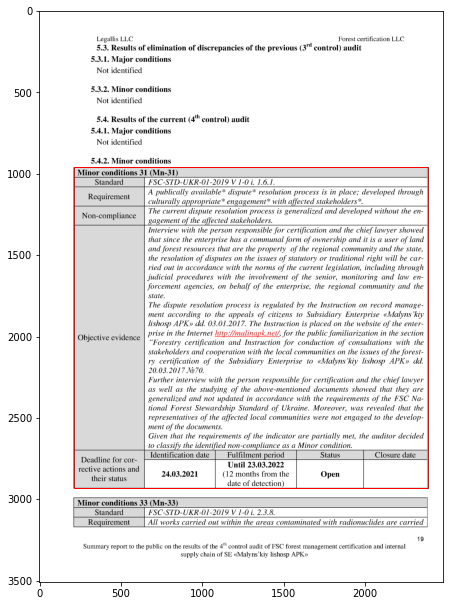

In [16]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

Видим тут полную таблицу, ее и будем брать за пример.

In [17]:
tables[0].df

,0,1,2,3,4
0,Minor conditions 31 (Mn-31),,,,
1,Standard,FSC-STD-UKR-01-2019 V 1-0 i. 1.6.1.,,,
2,Requirement,A publically available* dispute* resolution pr...,,,
3,Non-compliance,The current dispute resolution process is gene...,,,
4,Objective evidence,Interview with the person responsible for cert...,,,
5,Deadline for cor-\nrective actions and \ntheir...,Identification date,Fulfilment period,Status,Closure date
6,,24.03.2021,Until 23.03.2022 \n(12 months from the \ndate ...,Open,


In [18]:
# размер полной таблицы
tables[0].df.shape

(7, 5)

In [19]:
def check_shape(df)-> bool:
    '''
        Check shape of table (dataframe)
    '''
    return df.shape == (7,5)

In [20]:
check_shape(tables[0].df)

True

In [21]:
TITLE = 'Minor conditions'

def check_title(df)-> bool:
    """
    Check if title is in our table (dataframe)
    """
    return TITLE in df[0][0]

In [22]:
check_title(tables[0].df)

True

In [23]:
# атрибуты верха таблицы
TOP_ATTR = ['Standard']
# атрибуты низа таблицы
BOTTOM_ATTR = ['Deadline for cor-\nrective actions and \ntheir status', 'Identification date']
# главные атрибуты таблицы
MAIN_ATTR = TOP_ATTR + BOTTOM_ATTR

def check_attributes(df, attr: list)-> bool:
    """
    Check that table (dataframe) has all attributes from list attr
    function check only that table has this attrubutes, don't check their places
    """
    res = []
    for _attr in attr:
        res.append((df == _attr).values.sum())

    return np.all(np.array(res))      


In [24]:
check_attributes(tables[0].df, MAIN_ATTR)

True

In [25]:
def is_full_table(df) -> bool:
    """
    Check that table is full.
    """
    return check_shape(df) and \
        check_title(df) and \
        check_attributes(df, MAIN_ATTR)

In [26]:
is_full_table(tables[0].df)

True

### Если таблица на полная, то это верх таблицы или ее низ

In [27]:
def is_top_table(df)-> bool:
    """
    Check that table has top attributes and title
    """
    return check_title(df) and\
         check_attributes(df, TOP_ATTR)

In [28]:
is_top_table(tables[0].df)

True

In [29]:
def table_has_last_attribute(df)-> bool:
    """
    Check that table in last row has attribute (zero column), not only text
    """
    shape = df.shape
    return bool(df[0][shape[0]-1])

Как видим полная таблица не имеет последнего атрибута, но это нормально. Мы не будем проверять полные таблицы на наличие последнего атрибута. Эта проверка нужна только для неполных таблиц, которые нужно состыковать с их отсальной частью на другой странице.

In [30]:
table_has_last_attribute(tables[0].df)

False

In [31]:
def is_bottom_table(df)-> bool:
    """
    Check that table has bottom attributes
    """
    return check_attributes(df, BOTTOM_ATTR)

In [32]:
is_bottom_table(tables[0].df)

True

In [33]:
def table_has_first_attribute(df)-> bool:
    """
    Check that table in first row has attribute (zero column), not only text
    """
    # shape = df.shape
    return bool(df[0][0])

In [34]:
table_has_first_attribute(tables[0].df)

True

### Таблица наверху или внизу (ее край рядом с верхом\низом страницы)
- Верхняя граница таблицы находится рядом с верхом страницы (не выше на eps1 и не ниже на eps2)
- Нижняя граница таблицы находится рядом с низом страницы (не выше на eps1 и не ниже на eps2)

In [35]:
# Верхняя граница таблицы находится рядом с верхом страницы (не выше на eps1 и не ниже на eps2)
def check_top_table(table, eps1 = 3 ,eps2 = 10) ->bool:
    """
    Check that top of the table is in boundaries
    """

    top_table = table.cells[0][0].y2
    return  top_page - eps2 < top_table < top_page + eps1

In [36]:
check_top_table(tables[0])

False

In [37]:
# Нижняя граница таблицы находится рядом с низом страницы (не выше на eps1 и не ниже на eps2)
def check_bottom_table(table, eps1 = 15 ,eps2 = 3) ->bool:
    """
    Check that bottom of the table is in boundaries
    """

    top_table = table.cells[-1][-1].y1
    return  bottom_page - eps2 < top_table < bottom_page + eps1

In [38]:
check_bottom_table(tables[0])

False

### Склейка разорванных таблиц
  - распознать, что первая таблица неполная и **не нижняя**, а вторая -- неполная и нижняя.
  - Определить, есть ли атрибуты у последней и первой строк соответствующих таблиц
  - Вставить пустые столбцы в верхнюю таблицу (привести к правильному размеру по столбцам)
  - соединить таблицы. 
    - Если нет атрибута у верхней, то текст клеится к атрибуту нижней
    - Если нет атрибута у нижней, то текст клеится к атрибуту верхней
    - Если у обоих таблиц нет атрибута, то это ошибка.

Загрузим таблицы из 2 страниц и на их примере постараемся склеить таблицы.

In [39]:
tables = camelot.read_pdf(file, pages = '21,22')
# tables = camelot.read_pdf(file, pages = '24,25')
tables

<TableList n=5>

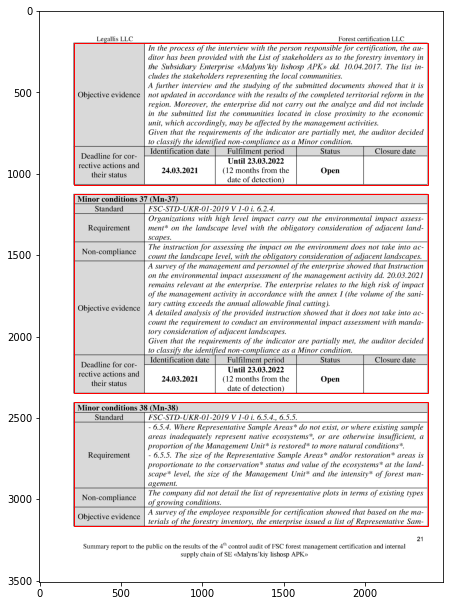

In [40]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

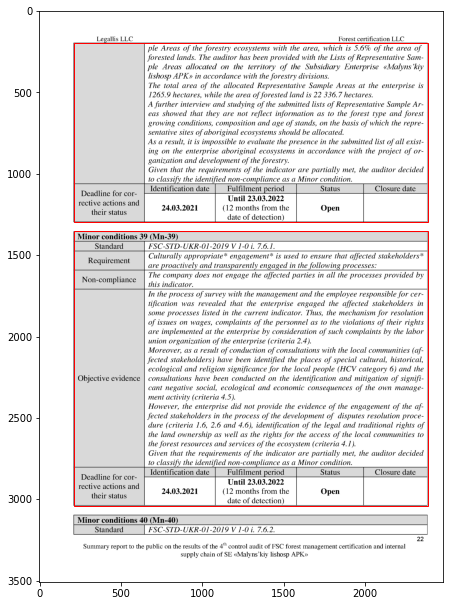

In [41]:
_p = camelot.plot(tables[3], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

In [42]:
df1 = tables[2].df
df1

,0,1
0,Minor conditions 38 (Mn-38),
1,Standard,"FSC-STD-UKR-01-2019 V 1-0 i. 6.5.4., 6.5.5."
2,Requirement,- 6.5.4. Where Representative Sample Areas* do...
3,Non-compliance,The company did not detail the list of represe...
4,Objective evidence,A survey of the employee responsible for certi...


In [43]:
df2 = tables[3].df
df2

,0,1,2,3,4
0,,ple Areas of the forestry ecosystems wit...,,,
1,Deadline for cor-\nrective actions and \ntheir...,Identification date,Fulfilment period,Status,Closure date
2,,24.03.2021,Until 23.03.2022 \n(12 months from the \ndate ...,Open,


In [44]:
(not is_full_table(df1)) and not is_bottom_table(df1)

True

In [45]:
(not is_full_table(df2)) and is_bottom_table(df2)

True

Как видим `df1` -- это верхняя часть таблицы, `df2` -- нижняя

Напишем функцию объединения таблиц

In [46]:
def concat_tables(df_top, df_bottom):
    """
    Concatenate tables, or 
    raise VAlueError if both tables don't have attribute
    """
    if table_has_last_attribute(df_top):
        if table_has_first_attribute(df_bottom):
            # соединение если обе таблицы имеют атрибуты
            # разрыв страницы не разорвал ячейку таблицы
            return pd.concat([df_top, df_bottom],ignore_index= True).fillna('')
        else:
            # нет атрибута у нижней таблицы
            last_row = df_top.shape[0]-1
            new_text = df_top[1][last_row] + df_bottom[1][0]
            df_bottom = df_bottom.drop(0)
            
            res = pd.concat([df_top, df_bottom],ignore_index= True).fillna('')
            res[1][last_row] = new_text
            return res
    else:
        if table_has_first_attribute(df_bottom):
            # нет атрибута у верхней таблицы
            last_row = df_top.shape[0]-1
            new_text =  df_top[1][last_row] + df_bottom[1][0]
            df_top = df_top.drop(last_row)
            
            res = pd.concat([df_top, df_bottom],ignore_index= True).fillna('')
            res[1][last_row] = new_text
            return res

        else:
            raise ValueError("Both tables don't have attribute")

In [47]:
_df = concat_tables(df1,df2)
_df

,0,1,2,3,4
0,Minor conditions 38 (Mn-38),,,,
1,Standard,"FSC-STD-UKR-01-2019 V 1-0 i. 6.5.4., 6.5.5.",,,
2,Requirement,- 6.5.4. Where Representative Sample Areas* do...,,,
3,Non-compliance,The company did not detail the list of represe...,,,
4,Objective evidence,A survey of the employee responsible for certi...,,,
5,Deadline for cor-\nrective actions and \ntheir...,Identification date,Fulfilment period,Status,Closure date
6,,24.03.2021,Until 23.03.2022 \n(12 months from the \ndate ...,Open,


In [48]:
_df[1][4]

'A survey of the employee responsible for certification showed that based on the ma-\nterials of the forestry inventory, the enterprise issued a list of Representative Sam-ple  Areas  of  the  forestry  ecosystems  with  the  area,  which  is  5.6%  of  the  area  of \nforested lands. The auditor has been provided with the Lists of Representative Sam-\nple  Areas  allocated  on \nthe \nterritory  of \nthe  Subsidiary  Enterprise  «Malyns’kiy \nlishosp APK» in accordance with the forestry divisions. \nThe  total  area  of  the  allocated  Representative  Sample  Areas  at  the  enterprise  is \n1265.9 hectares, while the area of forested land is 22 336.7 hectares. \nA further interview and studying of the submitted lists of Representative Sample Ar-\neas  showed  that  they  are  not  reflect  information  as  to  the  forest  type  and  forest \ngrowing conditions, composition and age of stands, on the basis of which the repre-\nsentative sites of aboriginal ecosystems should be alloca

In [49]:
_df[1][4] == df1[1][4] + df2[1][0]

True

### Распознавание нераспознанных таблиц.

Я считаю, что это верхние части таблиц, которые обрезались страницей. Для решения этого нам поможет прошлый пункт, если прошлая таблица не находится внизу, а следующая таблица неполная (низ таблицы), то значит мы пропустили верхнюю часть таблицы.
  - Проверяем есть ли нераспознанная таблица. За таблицей, которая не находится внизу (до низа страницы есть место) и **нижняя** стоит неполная нижняя таблица. Это говорит о том, что мы пропустили маленькую таблицу, начало второй таблицы.
  - Определяем область нераспознанной таблицы
  - Распознаем ее при помощи алгоритма `stream`
  - Как показала практика, не распознаются маленькие таблицы у которых текст занимает всего одну строку. Однако если текст напротив атрибута занимает больше строк, то строки распознаются некорректно. Поэтому нужно будет сделать перевод распознанной таблицы в приличный вид (склейка строк)
    - определить количество аргументов и количество строк текста. 
    - Если аргумент стоит напротив текста и в строке выше него есть другой аргумент, то это то все хорошо. Это значит, что для этого аргумента текст распознался одной строкой. 
    - **Пока не делаю** Если над аргументом есть пустые аргументы, то текст в этих строках принадлежит аргументу. Также будем Считать, что текст распознается симметрично. Поэтому посмотрим сколько строк текста над аргументом принадлежат ему и потом столько же строк текста под аргументом присвоим этому аргументу. **Под вопросом**

In [50]:
tables = camelot.read_pdf(file, pages='19,20')
tables

<TableList n=3>

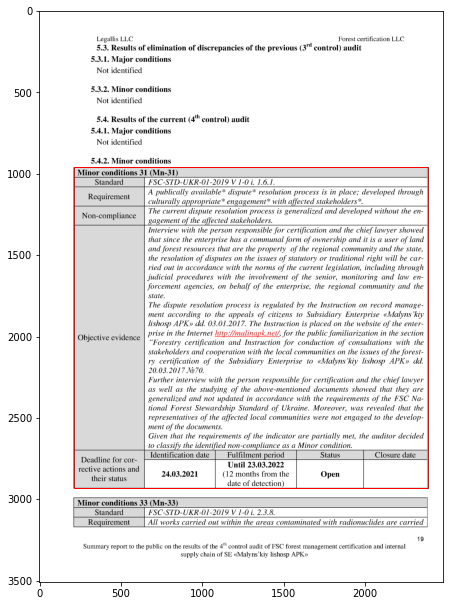

In [51]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

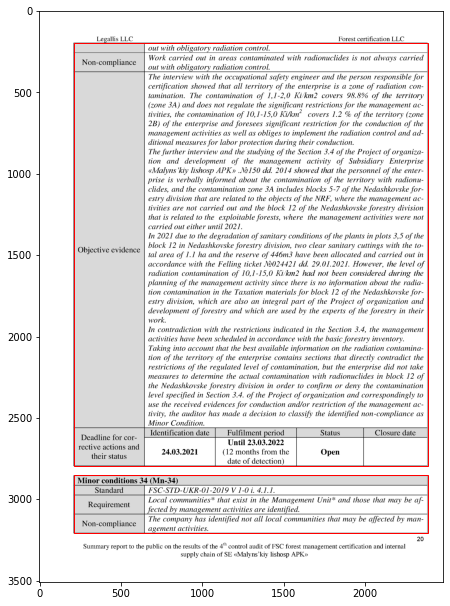

In [52]:
_p = camelot.plot(tables[2], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

Как видим на приведенных примерах у нас не распознается маленькая часть таблицы. Давайте ее распознаем.

In [53]:
def find_unrecognized_table_between_two_another (table1, table2) -> list:
    """
    check tables and if between they can exist another table function return table area
    or return empty str
    """
    res =''
    if (not check_bottom_table(table1)) and is_bottom_table(table1.df) and ((not is_full_table(table2.df)) and is_bottom_table(table2.df)):
        res = [0, int(table1.cells[-1][-1].y1), int(table1.cells[-1][-1].x2), int(bottom_page)]
        res = ','.join([str(i) for i in res])
    return res


In [54]:
table_area = find_unrecognized_table_between_two_another(tables[0], tables[1])
table_area

'0,138,572,72'

In [55]:
table_area = str(table_area)
table_area

'0,138,572,72'

In [56]:
test_table = camelot.read_pdf(file, pages = '19', table_areas=[table_area], flavor='stream')
test_table

<TableList n=1>

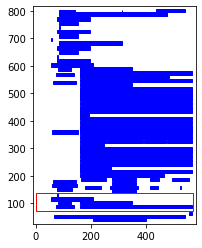

In [57]:
camelot.plot(test_table[0], kind='contour').show()
_p.set_size_inches(18.5, 10.5)
_p.show()

In [58]:
test_table[0].df

,0,1
0,Minor conditions 33 (Mn-33),
1,Standard,FSC-STD-UKR-01-2019 V 1-0 i. 2.3.8.
2,Requirement,All works carried out within the areas contami...


# Функция для извлечения таблиц из файла

Давайте соберем все ранее записанные идеи в одну тестовую функцию.

<!-- Давайте будем действовать таким образом. 
- Делаем цикл по всем страницам с таблицами
- За раз смотрим сразу 2 полные страницы. Это нужно для того, чтобы определить есть ли нераспознанные таблицы и склеить разорванные. 
- Если это первая или последняя страница, то будем проверять первую\последнюю таблицы для определения, что они не выходят за границу координат. Будем выкидывать лишние (те, что за границе) до тех пор пока не получим хорошую
- Проходимся по таблицам с двух страниц, если видим, что следующая таблица -- расположена наверху таблицы, то это конец первой страницы. В таком случае мы, смотрим есть ли разорванные или нераспознанные таблицы. Если они есть, то распознаем, склеиваем и отмечаем флагом, что на следующей итерации будем игнорировать первую таблицу. **Мы будем на итерации сохранять таблицы только с первой страницы (+ конец разорванной)** -->

Будем действовать следуя такому алгоритму.
1. Сканируем все страницы документа, на которых должны быть нужные нам таблицы. В результате получим список таблиц.
1. Далее будем изымать таблицы (что обнаружены на первой странице) их списка начиная с первой, если их конец расположен выше координат начала таблиц на первой странице
1. Теперь изымаем таблицы (что обнаружены на последней странице) с конца списка, если их начало ниже координат конца таблиц на последней странице
1. Теперь будем итерироваться по списку оставшихся таблиц.
    1. Проверяем текущую таблицу на полноту, если она полная, то записываем ее в список окончательных таблиц
    1. Если текущая таблица полная, а следующая таблица нижняя на новой странице, то мы не прспознали таблицу. Вычиляем область нераспознанной таблицы и ее странцу. Пытаемся рапознать таблицу при помощи `stream`. После этого вставляем распознаную таблицу в список таблиц, за текущей полной таблицей. 
    1. Если текущая таблица не полная, а верхняя, то смотрим на следующую таблицу, если она нижняя и сверху страницы (на следующей), то это конец текущей таблицы, соединяем таблицы, выкидываем их из списка рассматриваемых (смещаем указатель), записываем объединенную таблицу в список окончательных таблиц. Если следющая таблица не нижняя на новой странице, то выкидываем ислючение.
    1. Если текущая таблица нижняя, то выкидываем исключение. Ну или в любых других случаях.
    

In [71]:
tables[0].page

20

In [69]:
def choose_right_tables_in_start_page(tables, start_coord):

    pass

def choose_right_tables_in_end_page(tables, end_coord):
    
    pass


In [ ]:
def test_func(file_path):
    _pages_coords =  start_and_end_coords_pages(file)
    start_page, start_coord = _pages_coords[0]
    end_page, end_coord = _pages_coords[1]
    start_page, start_coord, end_page, end_coord

    part_table_flag = False

    for first_page in range(start_page, end_page+1):
        if first_page != end_page:
            second_page = first_page +1
            pages = f'{first_page},{second_page}'
        else:
            pages = f'{first_page}'
        
        # read tables
        tables = camelot.read_pdf(file, pages = pages)

        if first_page == start_page:
            tables = choose_right_tables_in_start_page(tables, start_coord)

        if first_page == end_page:
            tables = choose_right_tables_in_end_page(tables, end_coord)

        if part_table_flag:
            tables = tables[1:]

        index_table_2_page = len(tables)
        for index, table in enumerate(tables):
            if first_page != end_page and table.page == second_page:
                index_table_2_page = index
                break

        
